In [1]:
from helper import *
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import duckdb
from collections import Counter
from IPython.display import display as dp
import re
import warnings
from scipy.stats import chi2_contingency


# Filter out FutureWarnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

sns.set_style("darkgrid")

### EDA and Feature Selection

We would go through the EDA process by asking and answering questions. \
At the same time, we would select relevant features for modeling.

Note: \
As we want to predict game results for season `2015/2016`, to avoid data leak for \
modeling, some steps of the EDA process would only cover the seasons we'd use \
for training the model (2008/2009 ~ 2014/2015).

In [2]:
league = pd.read_csv("./data/league.csv")
game = pd.read_csv("./data/game.csv", parse_dates=["date"])
game_long = pd.read_csv("./data/game_long.csv", parse_dates=["date"])
bookie = pd.read_csv("./data/bookie.csv")
team = pd.read_csv("./data/team.csv")
player = pd.read_csv("./data/player.csv")
game_team_att = pd.read_csv("./data/game_team_att.csv")


# adjust type
game.home_formation = game.home_formation.fillna(0).astype("int").astype("str")
game.away_formation = game.away_formation.fillna(0).astype("int").astype("str")
game_long.formation = game_long.formation.fillna(0).astype("int").astype("str")
game_long.is_home = game_long.is_home.astype("int")

📊 What leagues and countries are in this dataset ?

In [3]:
dp(league)

,league_id,name,country
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France
3,7809,Germany 1. Bundesliga,Germany
4,10257,Italy Serie A,Italy
5,13274,Netherlands Eredivisie,Netherlands
6,15722,Poland Ekstraklasa,Poland
7,17642,Portugal Liga ZON Sagres,Portugal
8,19694,Scotland Premier League,Scotland
9,21518,Spain LIGA BBVA,Spain


📝 There are 11 leagues and 11 countries, each country has 1 league.

📊 Number of teams in leagues across time.


Teams in total: 
299

Teams in each country: 


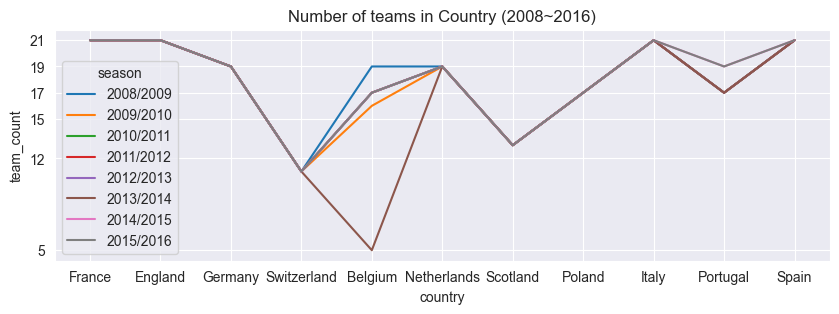

In [4]:
team_in_league = qry(
    """
SELECT 
  league.country country, 
  game.season season, 
  COUNT(DISTINCT(game.home_team_id))+1 team_count
FROM 
  game
JOIN
  league
ON
  game.league_id = league.league_id
GROUP BY
  game.league_id, league.country, game.season
ORDER BY
  game.season
"""
)

games_league_season = qry(
    """
SELECT
  game.season, 
  league.country
FROM
  game
JOIN
  league
ON
  game.league_id = league.league_id
ORDER BY
  game.season
"""
)

bprint("Teams in total: ")
print(game_long.team_id.nunique())
bprint("Teams in each country: ")

fs(10, 3)
ax = sns.lineplot(data=team_in_league, x="country",
                  y="team_count", hue="season")
plt.title("Number of teams in Country (2008~2016)")
plt.yticks([5, 12, 15, 17, 19, 21])
mark_bar(ax)

s()

📝 The number of teams in most countries are consistent across the years, \
one exception is Belgium in season 2013/2014, data is missing here. 

We would remove data in this season for Belgian League.

reference: wikipedia (Belgian Pro League)[https://en.wikipedia.org/wiki/Belgian_Pro_League]

In [5]:
# remove '2013/2014' belgian league data
game_long = qry(
    """
SELECT
  *
FROM
  game_long
WHERE
  NOT(season = '2013/2014' AND league_id = 1)    
"""
)

game = qry(
    """
SELECT
  *
FROM
  game
WHERE
  NOT(season = '2013/2014' AND league_id = 1)    
"""
)

📊 Which teams won the most league champions in each league ?

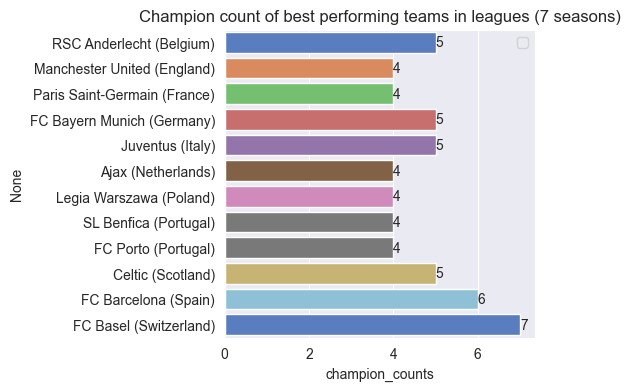

In [6]:
best_teams_in_countries = qry(
    """
WITH ranked_teams AS (
  SELECT
    game_long.league_id,
    league.country,
    season,
    team.team_long_name,
    RANK() OVER goals_rank_wd AS goals_rank,
    RANK() OVER points_rank_wd AS points_rank,
    SUM(points) total_points,
    COUNT(game_result) total_games,
    SUM(game_result)/ COUNT(game_result) win_proportion,
  
  FROM
    game_long
  JOIN
    team
  ON
    team.team_id = game_long.team_id  
  JOIN
    league
  ON
    game_long.league_id = league.league_id
  GROUP BY
    season,
    league.country,
    game_long.league_id,
    team.team_long_name
    
  WINDOW points_rank_wd AS (
    PARTITION BY
      season,
      game_long.league_id
    ORDER BY
      SUM(points) DESC
  ),
  
  goals_rank_wd AS (
    PARTITION BY
      season,
      game_long.league_id
    ORDER BY
      SUM(goal) DESC
  )    
)

SELECT
  country,
  team_long_name,
  RANK() OVER (
    PARTITION BY 
      country
    ORDER BY
      COUNT(team_long_name) DESC
  ) AS rank,
  COUNT(team_long_name) champion_counts
  
FROM
  ranked_teams
WHERE
  points_rank = 1 AND total_games > 10
GROUP BY
  country, team_long_name
ORDER BY
  country

"""
)

most_champion = qry(
    f"""
SELECT
  country,
  team_long_name AS team,
  champion_counts
FROM
  best_teams_in_countries
WHERE 
  rank = 1
"""
)
fs(4, 4)
ax = sns.barplot(
    y=most_champion.team + " (" + most_champion.country + ")",
    x=most_champion.champion_counts,
    hue=most_champion.country,
    palette="muted",
)
plt.legend("")
plt.title("Champion count of best performing teams in leagues (7 seasons)")
mark_bar(ax)
s()

📝 In certain nations, the premier team consistently secures the championship, \
such as in Spain and Switzerland.

Conversely, in countries like Portugal, two teams (FC Porto and SL Benfica) \
each achieved success in 4 championships.

📊 Compare the win and goal count of home and away team. 
- Is there home advantage ?


home team goal mean:
1.54

away team goal mean:
1.16


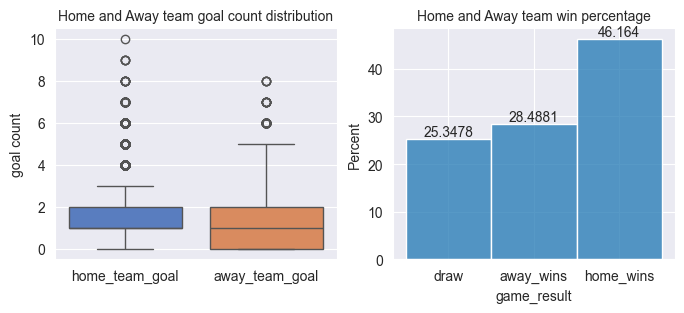

In [7]:
fs(8, 3)
# goal
plt.subplot(1, 2, 1)
sns.boxplot(
    game.loc[game.season != "2015/2016"][["home_team_goal", "away_team_goal"]],
    palette="muted",
)
plt.ylabel("goal count")
plt.title("Home and Away team goal count distribution", fontsize=10)

# win
plt.subplot(1, 2, 2)
ax = sns.histplot(
    game.loc[game.season != "2015/2016"].game_result,
    stat="percent",
    multiple="dodge",
    binwidth=1.4,
)
plt.title("Home and Away team win percentage", fontsize=10)

bprint("home team goal mean:")
print(round(game.home_team_goal.mean(), 2))
bprint("away team goal mean:")
print(round(game.away_team_goal.mean(), 2))

mark_bar(ax)
s()

📝 Is there home advantage ?

- home teams are scoring about 0.4 time more than away teams in each game 
- home teams win in around 46% of the games while away teams 28% 

> There is home advantage, this should be taken into consideration in modeling.

📊 Is the home wins difference among countries significant?

Check with hypothesis testing:

H0: There's no significant association between home team win and countries. \
Ha: There's is significant association between home team win and countries.

alpha = 0.05

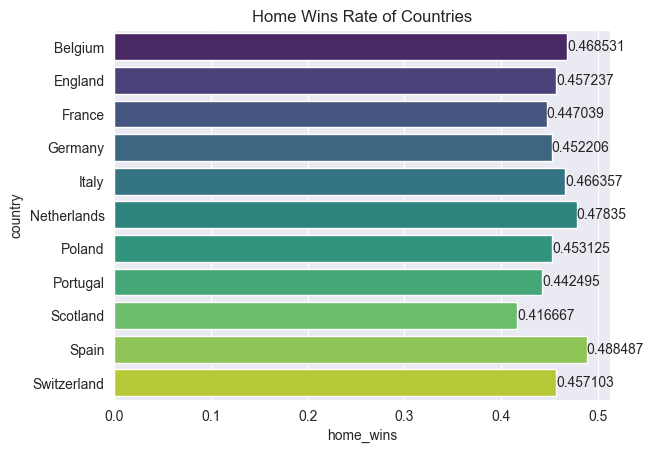


Test Result:
Chi-Squared Test Statistic: 33.561446699440914
p-value: 0.000219088806215155
Reject the null hypothesis: There is a significant association between country and home team win.


In [8]:
# only looking at win
country_home_wins = qry(
    f"""
SELECT
  league.country,
  CASE WHEN game_result = 'home_wins' THEN 1 ELSE 0 END AS home_wins
FROM
  game
JOIN
  league
ON
  game.league_id = league.league_id
      
"""
)


ax = sns.barplot(
    data=pd.DataFrame(
        country_home_wins.groupby("country").home_wins.mean()
    ).reset_index(),
    y="country",
    x="home_wins",
    palette="viridis",
)

mark_bar(ax)

plt.title("Home Wins Rate of Countries")
s()

contingency_table = pd.crosstab(
    country_home_wins["country"], country_home_wins["home_wins"]
)

chi2_statistic, p_value, _, _ = chi2_contingency(contingency_table)

bprint("Test Result:")
print("Chi-Squared Test Statistic:", chi2_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    print(
        "Reject the null hypothesis: There is a significant association between country and home team win."
    )
else:
    print(
        "Fail to reject the null hypothesis: There is no significant association between country and home team win."
    )

📝 Home team is winning more in all countries, although the degree of home advantage \
is different.


But why is there home advantage ? \
Can we try to explain this from our data ? 

We would look into different factors: 

1. Is certain formation more used by home team to win ?
2. Are teams using different players with different performance when they play \
at home ?

📊 Formations 
- What are some common soccer formations ?
- Do home and away team use different formations ? What is the impact on the \
outcome of the game ?

In [9]:
# formation line plot
form = qry(
    """
SELECT 
  'h: '|| home_formation || ', a: ' || away_formation AS formation,
  COUNT(game_result) count,

  COUNT(CASE WHEN game_result = 'home_wins' THEN 1 END)/COUNT(game_result) AS home_win_rate, 
  COUNT(CASE WHEN game_result = 'away_wins' THEN 1 END)/COUNT(game_result) AS away_win_rate,
  COUNT(CASE WHEN game_result = 'draw' THEN 1 END)/COUNT(game_result) AS draw_rate, 
  COUNT(CASE WHEN game_result = 'home_wins' THEN 1 END)/COUNT(game_result) - COUNT(CASE WHEN game_result = 'away_wins' THEN 1 END)/COUNT(game_result) AS win_rate_diff
FROM
  game
WHERE 
  (home_formation <> '0' AND away_formation <> '0')
  AND
  season <> '2015/2016'
GROUP BY
  home_formation,
  away_formation
HAVING
  COUNT(*) > 300
ORDER BY
  win_rate_diff DESC
"""
)


All different formations:
34


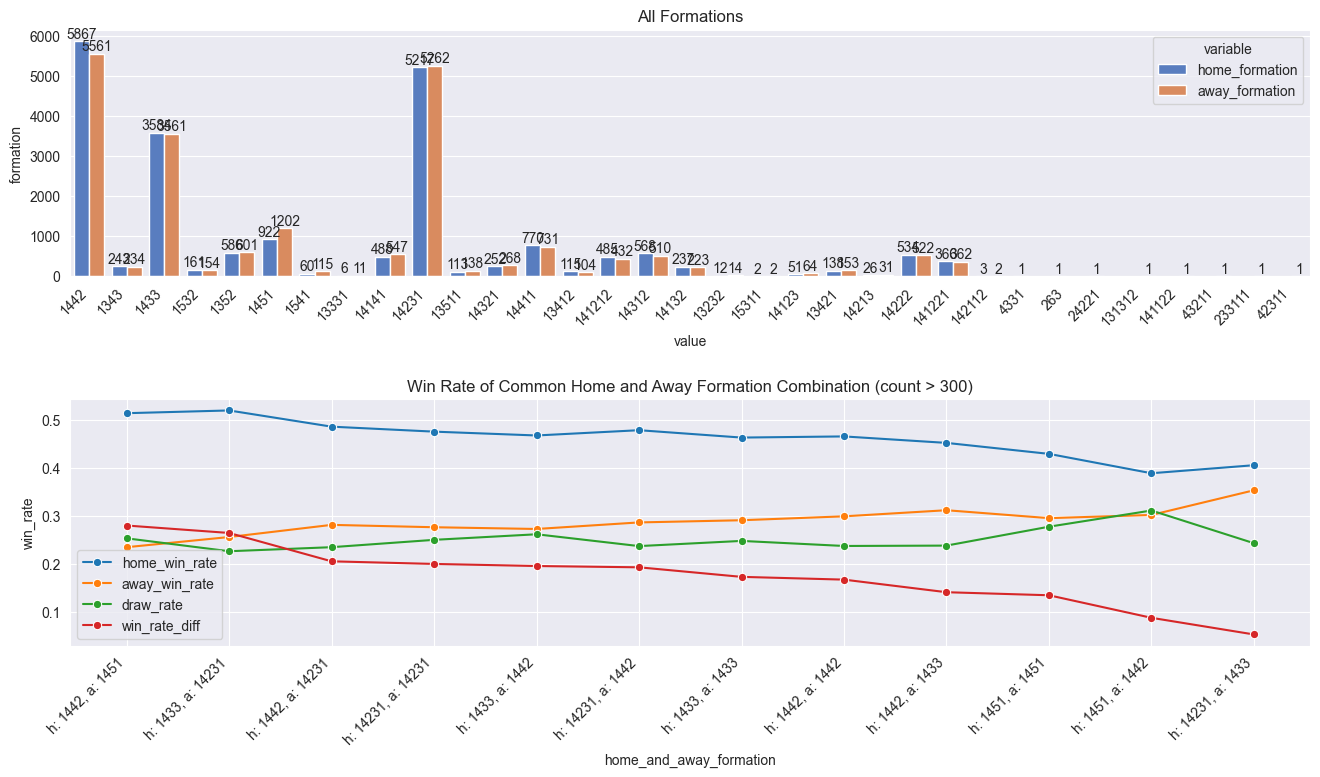


Win rate difference of home and away team:
0.1768

Different combinations with count > 300:


,formation,count,home_win_rate,away_win_rate,draw_rate,win_rate_diff
0,"h: 1442, a: 1451",487,0.513347,0.234086,0.252567,0.279261
1,"h: 1433, a: 14231",709,0.519041,0.255289,0.225670,0.263752
2,"h: 1442, a: 14231",645,0.485271,0.280620,0.234109,0.204651
3,"h: 14231, a: 14231",2550,0.474902,0.275686,0.249412,0.199216
4,"h: 1433, a: 1442",544,0.466912,0.272059,0.261029,0.194853
5,"h: 14231, a: 1442",588,0.477891,0.285714,0.236395,0.192177
6,"h: 1433, a: 1433",1602,0.462547,0.290262,0.247191,0.172285
7,"h: 1442, a: 1442",3351,0.464936,0.298418,0.236646,0.166517
8,"h: 1442, a: 1433",556,0.451439,0.311151,0.237410,0.140288
9,"h: 1451, a: 1451",336,0.428571,0.294643,0.276786,0.133929


In [26]:
formations = game.loc[game.season != "2015/2016"][["home_formation", "away_formation"]]
fs(16, 8)
gs = GridSpec(2, 3, hspace=0.5)

bprint("All different formations:")
print(len(list(Counter(formations.melt().value).keys())))

# formation barplot
plt.subplot(gs[0:1, 0:3])
ax = sns.countplot(
    data=formations.melt().dropna().loc[formations.melt().value != "0"],
    x="value",
    hue="variable",
    palette="muted",
)
mark_bar(ax)
plt.ylabel("formation")
plt.title("All Formations")
plt.xticks(rotation=45, ha="right")

# line plot
plt.subplot(gs[1:2, 0:3])

sns.lineplot(
    data=form, x="formation", y="home_win_rate", label="home_win_rate", marker="o"
)
plt.xticks(rotation=45, ha="right")
sns.lineplot(
    data=form, x="formation", y="away_win_rate", label="away_win_rate", marker="o"
)
sns.lineplot(data=form, x="formation", y="draw_rate", label="draw_rate", marker="o")

ax = sns.lineplot(
    data=form, x="formation", y="win_rate_diff", label="win_rate_diff", marker="o"
)
mark_bar(ax)

plt.ylabel("win_rate")
plt.xlabel("home_and_away_formation")
plt.title("Win Rate of Common Home and Away Formation Combination (count > 300)")
s()

bprint("Win rate difference of home and away team:")
print(0.1768)
bprint("Different combinations with count > 300:")
dp(form)

📝 Formations

There are 35 different kind of formations in this dataset. \
Here we show the win rate of common formation combinations. 

- Different formation combinations yields very different game result, for the \
common combinations here, the difference for home_win_rate - away_win_rate \
ranges from 0.27 to 0.04. 

> formation combination should be considered for modeling. \
> `win_rate_diff` would be used as a predictor.

In [11]:
# add formation diff score to game
form_diff_map = qry(
    """
SELECT 
  home_formation,
  away_formation,
  COUNT(CASE WHEN game_result = 'home_wins' THEN 1 END)/COUNT(game_result) - COUNT(CASE WHEN game_result = 'away_wins' THEN 1 END)/COUNT(game_result) AS win_rate_diff
FROM
  game
WHERE 
  (home_formation <> '0' AND away_formation <> '0')
  AND
  season <> '2015/2016'
GROUP BY
  home_formation,
  away_formation
"""
)

game = qry(
    """
SELECT
  game.*, 
  map.win_rate_diff AS formation_win_rate_diff
FROM
  game
LEFT JOIN
  form_diff_map as map
ON 
  game.home_formation == map.home_formation
  AND
  game.away_formation == map.away_formation
"""
)

📊 Player scores
- What is the distribution of player scores for different player position ?
- Is there a difference between the mean player score of home and away teams ?
- Does player score impact the outcome of the game ?

In [12]:
# plot data for comparing home and away player scores
score_columns = find_list_pattern(r"player_.*score$", game_long)

home_score_columns = find_list_pattern(r"home_.*score$", game)
away_score_columns = find_list_pattern(r"away_.*score$", game)

score_dist = game_long.loc[game_long.season !=
                           "2015/2016"][score_columns].melt()
score_dist["is_home"] = (
    game_long.loc[game_long.season != "2015/2016"].is_home.tolist() * 11
)
score_dist.is_home = score_dist.is_home.apply(
    lambda i: ("away", "home")[i == 1])

p_point_game_qry = qry(
    f"""
SELECT
  CASE
    WHEN home_player_score_mean > away_player_score_mean THEN 'home > away'
    WHEN home_player_score_mean  < away_player_score_mean THEN 'away > home'
    ELSE 'home = away'
  END AS player_score_comparison,
  game_result
FROM
  game
WHERE
  game.season <> '2015/2016'
  
"""
)

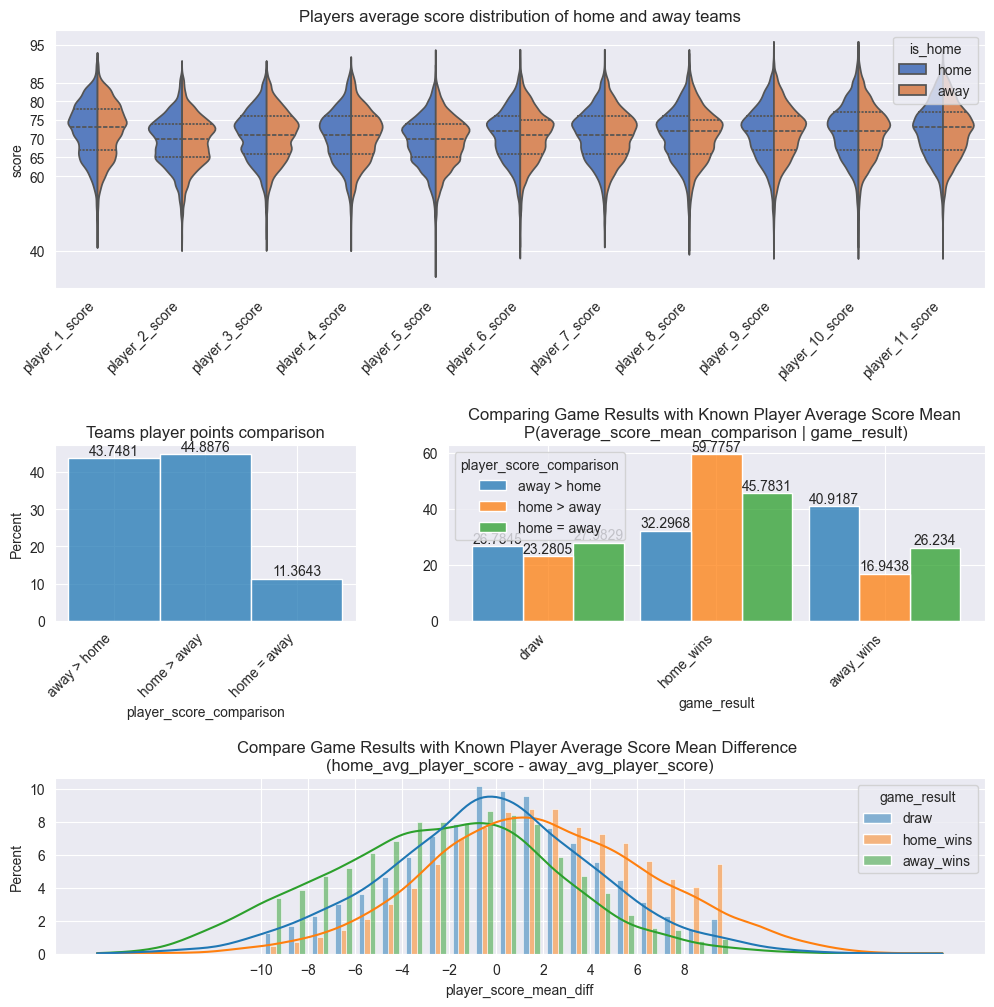

In [27]:
fs(12, 12)
# score distribution
gs = GridSpec(12, 12, hspace=8)
plt.subplot(gs[0:4, 0:12])

ax = sns.violinplot(
    data=score_dist,
    y="value",
    x="variable",
    hue="is_home",
    split=True,
    inner="quart",
    palette="muted",
)
plt.title("Players average score distribution of home and away teams")
plt.ylabel("score")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.yticks([40, 60, 65, 70, 75, 80, 85, 95])

# home and away comparison
plt.subplot(gs[5:8, 0:4])

ax = sns.histplot(p_point_game_qry.player_score_comparison, stat="percent")
mark_bar(ax)
plt.title("Teams player points comparison")
plt.xticks(rotation=45, ha="right")


# P(score_comparison |game_result)
plt.subplot(gs[5:8, 5:12])

ax = sns.histplot(
    data=p_point_game_qry,
    # x="player_score_comparison",
    # hue="game_result",
    x="game_result",
    hue="player_score_comparison",
    stat="percent",
    multiple="dodge",
    shrink=0.9,
    common_norm=False,
)
mark_bar(ax)
plt.title(
    "Comparing Game Results with Known Player Average Score Mean \nP(average_score_mean_comparison | game_result)"
)
plt.ylabel("")
plt.xticks(rotation=45, ha="right")

plt.subplot(gs[9:12, 0:12])

ax = sns.histplot(
    data=game,
    x="player_score_mean_diff",
    hue="game_result",
    multiple="dodge",
    stat="percent",
    binwidth=1,
    binrange=(-10, 10),
    shrink=0.7,
    kde=True,
    common_norm=False,
)
plt.xticks(range(-10, 10, 2))
plt.title(
    "Compare Game Results with Known Player Average Score Mean Difference \n(home_avg_player_score - away_avg_player_score)"
)
plt.subplots_adjust(hspace=0.8)
s()

📝 Player score in games

⚽️ The player scores violin plots have shown that: 
- home and away team players have similar overall score distribution in most \
player positions except small difference in 2 players: \
For `player_6, and player_8`, home teams have higher scores. There's no player \
that has higher score in away team.

> This might be one source of home advantage, teams use better performing \
players at home.


⚽️ The barplot comparing home and away mean player scores have shown that the \
percentage of home > away and away > home is very similar the difference is \
only about 1%. 


⚽️ The barplot comparing game result with player scores have \
shown that:
- When a team has higher score, the chance to win is always higher. However, when \
home team has higher score, the chance to win is almost 20% higher than when \
away team has higher score.


⚽️ The histplot comparing game result with known score_difference have shown that:

- With the increase of player_avg_score difference, the chance for winning also \
increases for both home and away team.

- Once a team has higher score than its competeing team, the chance of winning \
is higher than the opponent.

- The distribution of draw is sitting in the middle of home wins and away wins \
distribution.

- The chance for draw is the highest when the score difference ranges from \
-1 ~ 2.


> To sum up: `is_home_team` and `player_avg_score_difference` are crucial \
> predictors for game results.


Now, let's compare the team attributes score difference of competing teams.

📊 What is the correlation between team attribute difference of the teams and \
game result ? 
- Are some team attributes good indicators for predicting game result ?

The team attribute classes are encoded to `-1, 0, 1` OR `-1, 1` depends on the \
number of classes for the attribute.

The game results are: `1, 0, -1` which stands for win, draw, lose.

Here we substract the team attributes of home by away, and check its \
correlation with game result.


team attributes
['build_up_play_speed_class', 'build_up_play_dribbling_class', 'build_up_play_passing_class', 'build_up_play_positioning_class', 'chance_creation_passing_class', 'chance_creation_crossing_class', 'chance_creation_shooting_class', 'chance_creation_positioning_class', 'defence_pressure_class', 'defence_aggression_class', 'defence_team_width_class', 'defence_defender_line_class']

Distribution of team attribute encode


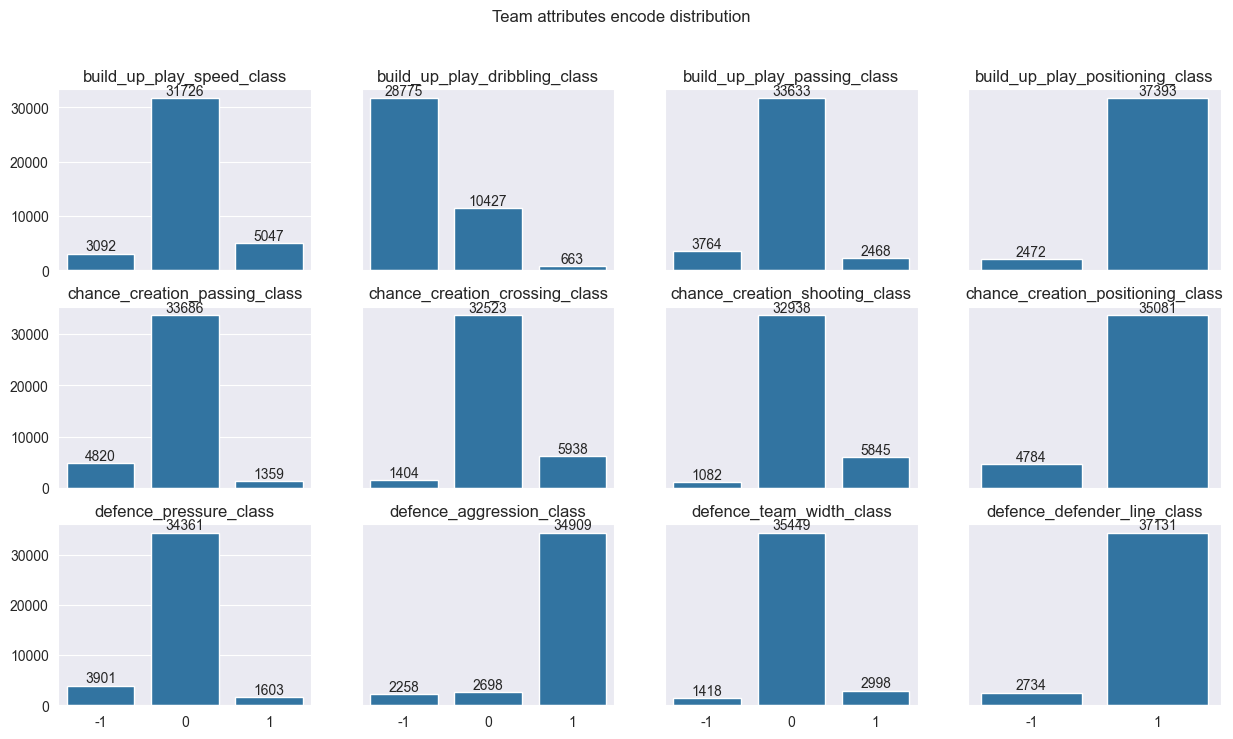

In [14]:
class_cols = find_list_pattern(r".*class$", game_team_att.columns)

bprint("team attributes")
print(class_cols)

bprint("Distribution of team attribute encode")
fs(15, 8)
counter = 1
for i in class_cols:
    plt.subplot(3, 4, counter)
    ax = sns.barplot(Counter(game_team_att[i]))
    mark_bar(ax)
    plt.title(i)

    if counter % 4 != 1:
        plt.yticks([])
    if counter < 9:
        plt.xticks([])
    counter += 1
plt.suptitle("Team attributes encode distribution")
s()

In the distribution of attributes encode, majority of the teams are in the same \
encode group. 

Let's check the attribute's correlation with game result, here we also look at \
the mean of all attributes.

In [15]:
# correlation of teams attribute and game results
def team_att_rep_qry(ls):
    acc = ""
    for i in ls:
        rep = f"""
        home.{i} - away.{i} AS {i}_diff,
        """

        acc = acc + "\n" + rep
    return acc


team_att_game_result_qry = qry(
    f"""
  WITH 
  home AS (
  SELECT
    *
  FROM
    game_team_att
  WHERE
    is_home = 1    
  ),

  away AS (
  SELECT
    *
  FROM
    game_team_att
  WHERE
    is_home = 0
  )

  SELECT
    home.game_result,
    {team_att_rep_qry(class_cols)}
  FROM
    home
  JOIN
    away
  ON
    home.game_id = away.game_id    
  """
)

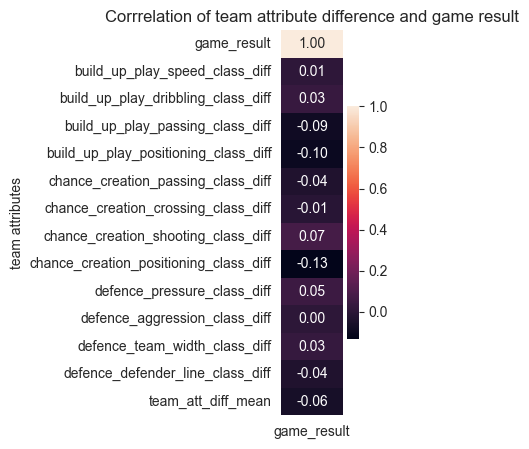

In [16]:
diff_cols = find_list_pattern(r".*_diff$", team_att_game_result_qry.columns)
# add sum of team_att difference into correlation comparison
team_att_game_result_qry["team_att_diff_mean"] = team_att_game_result_qry[
    diff_cols
].mean(axis=1)

fs(1, 5)
sns.heatmap(
    pd.DataFrame(team_att_game_result_qry.corr(method="kendall").game_result),
    annot=True,
    fmt=".2f",
)
plt.ylabel("team attributes")
plt.title("Corrrelation of team attribute difference and game result")
s()

> All team_attributes_difference of teams have no correlation with *single* game 
> result !

However, we do know that there are some teams in leagues that constatly won \
the championships, are there really no attributes that stand out in these teams ?

- Here, instead of looking at a single game, we look at the team attributes and \
the game result of teams `throughout the years`. 

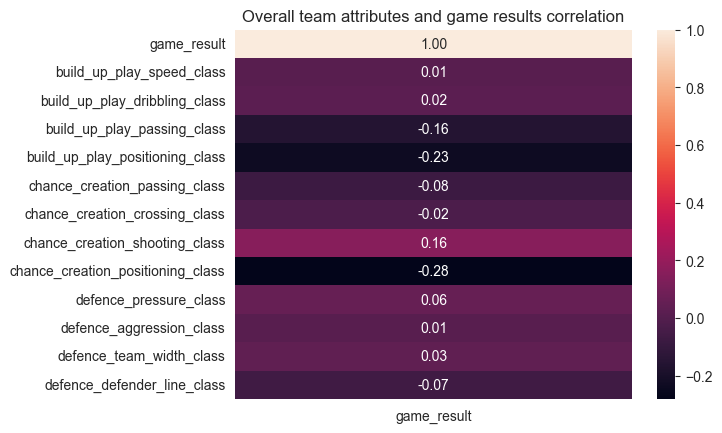

In [17]:
player_cols = find_list_pattern(r".*_score$", game_team_att.columns)


def team_att_class_sum_rep_qry(ls):
    acc = ""
    for i in ls:
        cur = f"""
        AVG({i}) AS {i},
        """
        acc = acc + cur
    return acc


overall_team_attribute_corr_game_result = qry(
    f""" 
SELECT
  AVG(game_result) AS game_result,
  {team_att_class_sum_rep_qry(class_cols)}
  
FROM
  game_team_att
GROUP BY
  league_id,
  season,
  team_id
"""
)
sns.heatmap(
    pd.DataFrame(overall_team_attribute_corr_game_result.corr().game_result),
    annot=True,
    fmt=".2f",
)
plt.title("Overall team attributes and game results correlation")
s()

Here we can see some team attributes with weak positive correlation, and some \
weak negative correlation with the game result.

📝 Team attributes & game result

There's no strong correlation between the difference of team attributes and \
the result of single games.

- If we look at the aggregated data throughout the years, we can find some \
correlation.

- It is hard to predict the result of a single game by comparing the team \
attributes of competing teams.

> We won't use team attributes as predictor in modeling

📊 Can past game records of teams be used to predict game result ?

When predicting the outcome of games, we often base our guess heavily on the \
past performance of the teams, let's look at the rank trend of teams across years.

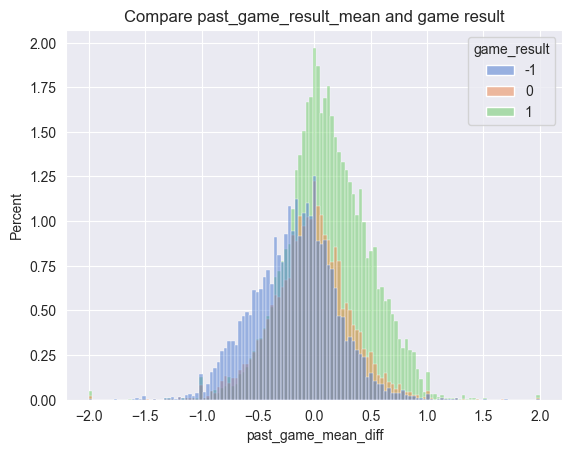

In [18]:
# get game_result_avg just before the game to avoid data leak

past_game_results_qry = qry(
    f"""
WITH past_result AS (
  SELECT
  *,
  AVG (CAST(game_result AS FLOAT)) OVER(
    PARTITION BY 
      team_id
    ORDER BY
      EPOCH(date)
    RANGE BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
  ) past_game_mean
FROM
  game_long),
  
  home AS (
    SELECT 
      *
    FROM
      past_result
    WHERE 
      is_home = 1
  ),
  
  away AS (
    SELECT
      *
    FROM
      past_result
    WHERE
      is_home = 0
  )
  
  SELECT
    home.past_game_mean - away.past_game_mean AS past_game_mean_diff,
    home.game_result AS game_result,
    home.player_score_mean - away.player_score_mean AS player_score_diff,
  FROM
    home
  JOIN
    away
  ON
    home.game_id = away.game_id
  
"""
)

sns.histplot(
    data=past_game_results_qry,
    x="past_game_mean_diff",
    hue="game_result",
    palette="muted",
    stat="percent",
)
plt.title("Compare past_game_result_mean and game result")
s()

📝 This plot have shown that, the higher the past game result mean, the chance \
for winning (1) the current game is also higher, and vice versa.

- Draw (0) is completely overlapping with winning (1) and losing (-1), it is hard \
to tell it apart from the others.

> performance in the past is a good predictor for the game result of the current \
game.

In [19]:
# add the past performance to our table

game_long = qry(
    """
SELECT
  *, 
  AVG(CAST(game_result AS FLOAT)) OVER (
      PARTITION BY
        team_id
      ORDER BY
        EPOCH(date)
      RANGE BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING 
  ) AS past_game_results
FROM
  game_long   
"""
)

bprint("past game results: ")
game_long[["team_id", "date", "game_result", "past_game_results"]].head()


past game results: 


,team_id,date,game_result,past_game_results
0,7730,2011-07-20,-1,NaN
1,7730,2011-07-30,1,-1.000000
2,7730,2011-08-03,-1,0.000000
3,7730,2011-08-06,-1,-0.333333
4,7730,2011-08-14,-1,-0.500000


The first game of each team would have no past_game_results.

In [20]:
# fill the NaN of past_game_results using backfill
game_long.past_game_results = game_long.past_game_results.fillna(
    method="bfill")

📊 Now we can select the predictors for modeling: \
After the eda, we have decided to use:

1. past game results average difference of formation combinations.
2. player score mean difference (home - away)
3. past game result difference (home - away)

to construct the prediction model.

In [21]:
soccer_modeling = qry(
    f"""
WITH
home AS (
    SELECT
      game_id,
      team_id,
      past_game_results,
    FROM
      game_long
    WHERE
      is_home = 1
),
away AS (
    SELECT
      game_id,
      team_id,
      past_game_results,
    FROM
      game_long
    WHERE
      is_home = 0
),

past_game_res_diff_te AS (
    SELECT
      home.game_id,
      home.past_game_results - away.past_game_results AS past_game_result_diff,
    FROM
      home
    JOIN
      away
    ON
      home.game_id = away.game_id
)


SELECT
  game.game_id,
  league.country AS country,
  game.season,
  game.home_team_id,
  game.away_team_id,
  game.player_score_mean_diff,
  te.past_game_result_diff,
  game.formation_win_rate_diff,
  game.game_result,
  game.home_team_goal - game.away_team_goal AS goal_diff
FROM
  game
JOIN
  past_game_res_diff_te AS te
ON game.game_id = te.game_id
JOIN
  league
ON
  league.league_id = game.league_id

"""
)
soccer_modeling = soccer_modeling.drop_duplicates()

# fill null values for player_score_mean_diff with the mean in each leagues
league_player_mean = soccer_modeling.groupby(
    "country").player_score_mean_diff.mean()
league_player_mean_key = list(league_player_mean.index)
league_player_mean_value = list(league_player_mean.values)
league_player_mean_dict = {
    league_player_mean_key[i]: league_player_mean_value[i]
    for i in range(len(league_player_mean_key))
}

In [22]:
soccer_modeling.to_csv("./data/soccer_modeling.csv", index=False)

bprint("Features for modeling: ")
soccer_modeling.tail(3)


Features for modeling: 


,game_id,country,season,home_team_id,away_team_id,player_score_mean_diff,past_game_result_diff,formation_win_rate_diff,game_result,goal_diff
25964,9792,Germany,2014/2015,9904,9823,-10.0,-0.629956,0.055556,away_wins,-2
25965,17340,Poland,2014/2015,8673,8020,4.0,0.353817,0.258065,draw,0
25966,967,Belgium,2011/2012,9997,9987,-4.0,-0.318933,0.000000,away_wins,-1


---
💡 EDA and Feature Selection summary: \
In this notebook we have discovered: 

1. Number of teams in leagues across time is mostly constant.

2. Teams that won the most championship in each leagues.
3. There is home advantage, we can see it in both win rates and goal counts.
4. Home teams win more in all countries, but the differance among countries are \
significantly different from one another.
5. Compare the win rate for different formation combinations of home and away teams.
6. One source of home advantage is coming from the use of better players at home.
7. Team attributes have no correlation with the result of single games, but the \
long-time trend of team performance has.
8. Teams that have performed better in past games also have higher chance to \
win the current game.
9. Features selected for modeling.

👋 The next part of this project is in the `3_modeling.ipynb` notebook.